# Borisov Dmitriy (6133-010402D)

Установка библиотеки numba

In [1]:
!pip install pycuda

In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import pycuda.autoinit
from pycuda import driver as cuda, compiler, tools
tools.make_default_context().get_device().name()

'Tesla K80'

In [3]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


Написание кода ядра

In [4]:
vecsum_kernel = """
__device__ void warpReduce(volatile int* shared_memory, int tid) {
	shared_memory[tid] += shared_memory[tid + 32];
	shared_memory[tid] += shared_memory[tid + 16];
	shared_memory[tid] += shared_memory[tid + 8];
	shared_memory[tid] += shared_memory[tid + 4];
	shared_memory[tid] += shared_memory[tid + 2];
	shared_memory[tid] += shared_memory[tid + 1];
}

// функция ядра
// выполнение суммирования элементов массива на GPU
__global__ void vecSumKernel(int* vec, int* res) {
	// выделение shared памяти 
	__shared__ int shared_memory[2048];
	// расчет идентификатора потока
	int tid = threadIdx.x;
	// загрузка элементов
	// расчет масштабируемого индекса так как размер массива
	// в два раза больше чем имеющееся количество потоков
	int i = blockIdx.x * (blockDim.x * 2) + tid;
	// Сохранение первой подсчитанной частичной суммы, помимо элементов
	shared_memory[tid] = vec[i] + vec[i + blockDim.x];
	__syncthreads();
	// цикл начинаем с половины блока и делим его на две части каждую итерацию
	for (int s = blockDim.x / 2; s > 32; s >>= 1) {
		if (tid < s) {
			shared_memory[tid] += shared_memory[tid + s];
		}
		__syncthreads();
	}
	if (tid < 32) {
		warpReduce(shared_memory, tid);
	}
	// Поток 0 для определенного блока результат будет писать в основную память
	// А результат индексируется этим блоком
	if (tid == 0) {
		res[blockIdx.x] = shared_memory[0];
	}
}
"""

vecsum = compiler.SourceModule(vecsum_kernel).get_function("vecSumKernel")


Расчёт времени суммирования вектора

In [5]:
mean_times_Numpy_vecsum = []     # Средние времена суммирования с numpu (numpy.sum())
mean_times_Python_vecsum = []    # Средние времена суммирования со стандартным sum()
mean_times_GPU_vecsum = []      # Массив, содержащий средние времена вычислений на GPU
sizes = np.array([2**i for i in range(10, 20)])   
count_iteration = 10            # Количество итераций без "холодного старта"
BLOCK_SIZE = 512                # Размерность одного блока

for size in sizes:
  # Создание данных и выделение памяти на CPU
  host_vec = np.ones(size, dtype=np.int32)
  host_res = np.zeros(size, dtype=np.int32)
  

  dev_vec = cuda.mem_alloc(host_vec.nbytes)
  dev_res = cuda.mem_alloc(host_res.nbytes)

  bdim = (BLOCK_SIZE, 1, 1)
  grid_dim = int((size + BLOCK_SIZE - 1) / (BLOCK_SIZE * 2))

  # Массивы с временами на соответствующем устройстве для вычисления среднего 
  times_Numpy_vecsum = []
  times_Python_vecsum = []
  times_GPU_vecsum = []
  python_sum = 0
  numpy_sum = 0

  for _ in range(count_iteration + 1):

    # Вычисление времени на GPU (с учётом пересылки данных)
    start_time = time()
    cuda.memcpy_htod(dev_vec, host_vec)
    cuda.memcpy_htod(dev_res, host_res)
    vecsum(dev_vec, dev_res, block=(BLOCK_SIZE, 1, 1), grid=(grid_dim, 1))
    vecsum(dev_res, dev_res, block=(BLOCK_SIZE, 1, 1), grid=(1, 1))
    cuda.memcpy_dtoh(host_res, dev_res)
    end_time = time()
    times_GPU_vecsum.append(end_time - start_time)

    # Суммирование с помощью стандартного sum
    start_time = time()
    python_sum = sum(host_vec)
    end_time = time()
    times_Python_vecsum.append(end_time - start_time)

    # Суммирование с помощью numpy
    start_time = time()
    numpy_sum = np.sum(host_vec)
    end_time = time()
    times_Numpy_vecsum.append(end_time - start_time)


  # Вычтсление среднего значения времени без "холодного старта"
  mean_times_GPU_vecsum.append(np.mean(times_GPU_vecsum[1:]))
  mean_times_Python_vecsum.append(np.mean(times_Python_vecsum[1:]))
  mean_times_Numpy_vecsum.append(np.mean(times_Numpy_vecsum[1:]))

  # Сравнение результатов
  print(f"Size = {size}; Grid = {grid_dim}.\t Numpy: {numpy_sum}\tPython: {python_sum}\tGPU: {host_res[0]}\
        \t{numpy_sum == python_sum == host_res[0]}")

print(f"GPU = {mean_times_GPU_vecsum}")
print(f"Python = {mean_times_Python_vecsum}")
print(f"Numpy = {mean_times_Numpy_vecsum}")

Size = 1024; Grid = 1.	 Numpy: 1024	Python: 1024	GPU: 1024        	True
Size = 2048; Grid = 2.	 Numpy: 2048	Python: 2048	GPU: 2048        	True
Size = 4096; Grid = 4.	 Numpy: 4096	Python: 4096	GPU: 4096        	True
Size = 8192; Grid = 8.	 Numpy: 8192	Python: 8192	GPU: 8192        	True
Size = 16384; Grid = 16.	 Numpy: 16384	Python: 16384	GPU: 16384        	True
Size = 32768; Grid = 32.	 Numpy: 32768	Python: 32768	GPU: 32768        	True
Size = 65536; Grid = 64.	 Numpy: 65536	Python: 65536	GPU: 65536        	True
Size = 131072; Grid = 128.	 Numpy: 131072	Python: 131072	GPU: 131072        	True
Size = 262144; Grid = 256.	 Numpy: 262144	Python: 262144	GPU: 262144        	True
Size = 524288; Grid = 512.	 Numpy: 524288	Python: 524288	GPU: 524288        	True
GPU = [9.360313415527344e-05, 0.00010733604431152343, 0.000118255615234375, 0.00012750625610351561, 0.0002947807312011719, 0.00020475387573242186, 0.000786590576171875, 0.0008138656616210937, 0.0013946771621704101, 0.001772022247314453

Сравнение скоростей трёх реализаций

Text(0.5, 0, 'Размерность, N')

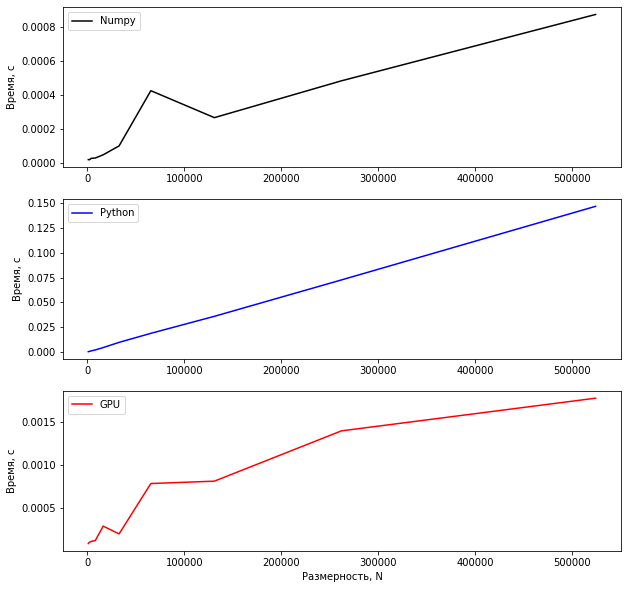

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(sizes, mean_times_Numpy_vecsum, color="black", label="Numpy")
axes[0].legend()
axes[0].set_ylabel("Время, с")
axes[1].plot(sizes, mean_times_Python_vecsum, color="blue", label="Python")
axes[1].legend()
axes[1].set_ylabel("Время, с")
axes[2].plot(sizes, mean_times_GPU_vecsum, color="red", label="GPU")
axes[2].legend()
axes[2].set_ylabel("Время, с")
axes[2].set_xlabel("Размерность, N")

Визуализация ускорения на GPU

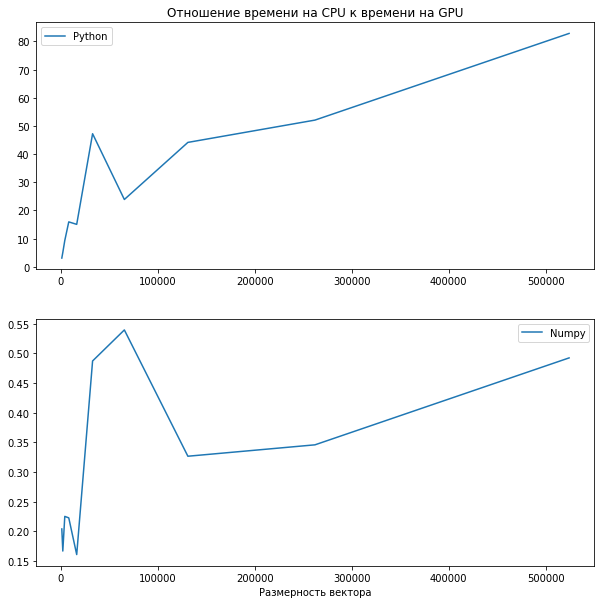

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(sizes, np.array(mean_times_Python_vecsum) / np.array(mean_times_GPU_vecsum), label="Python")
axes[1].plot(sizes, np.array(mean_times_Numpy_vecsum) / np.array(mean_times_GPU_vecsum), label="Numpy")
axes[0].set_title("Отношение времени на CPU к времени на GPU")
axes[1].set_xlabel("Размерность вектора")
axes[0].legend()
axes[1].legend()

Сохранение результатов в excel

In [8]:
df = pd.DataFrame({"Numpy": mean_times_Numpy_vecsum, "Python": mean_times_Python_vecsum, "GPU": mean_times_GPU_vecsum}, index=sizes)
df.to_excel("CPU and GPU.xlsx")
df

,Numpy,Python,GPU
1024,0.000019,0.000286,0.000094
2048,0.000018,0.000539,0.000107
4096,0.000027,0.001100,0.000118
8192,0.000028,0.002028,0.000128
16384,0.000047,0.004430,0.000295
32768,0.000100,0.009667,0.000205
65536,0.000424,0.018770,0.000787
131072,0.000266,0.035921,0.000814
262144,0.000482,0.072600,0.001395
524288,0.000872,0.146789,0.001772
